# 2D FEM SOLVER : ALLEN-CAHN EQUATION

In [1]:
import sympy as sym
import numpy as np
from scipy.interpolate import *
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

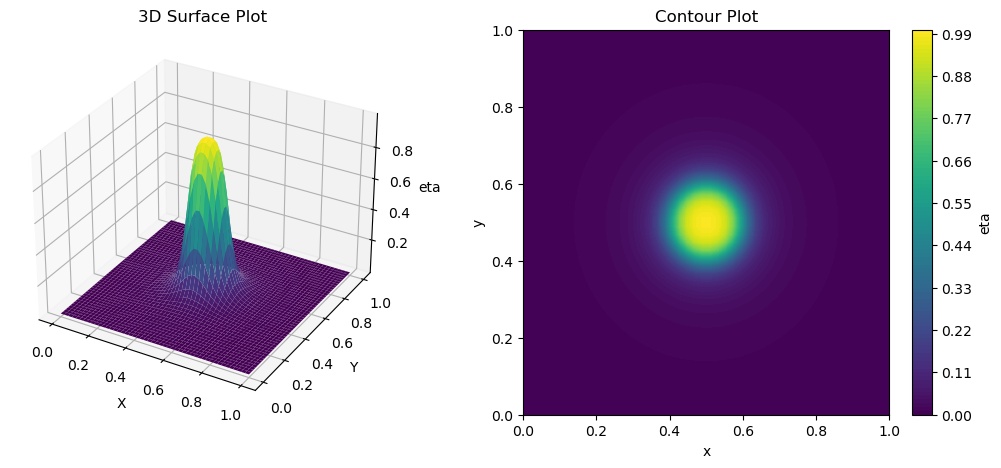

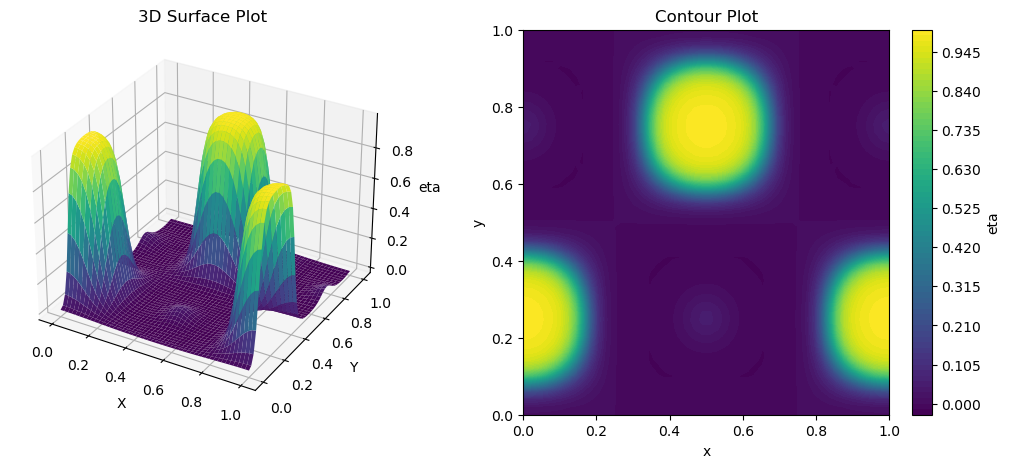

In [2]:
t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy') #Double well Potential

def one_dim_M_K(x, ndofs,degree):
    
    basisfun = [PPoly.from_spline(splrep(x, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]
    dbasisfun = [basisfun[i].derivative(1) for i in range(len(basisfun))]
    
    m = len(basisfun)
    intervals = np.unique(basisfun[0].x)
    
    q, w = roots_legendre(degree)
    q += 1.
    q /= 2.
    w /= 2.           
    
    h = np.diff(intervals)
    Q = np.array([intervals[i] + h[i] * q for i in range(len(h))]).reshape((-1,))
    W = np.array([w * h[i] for i in range(len(h))]).reshape((-1,))

    Bq = np.array([basisfun[i](Q) for i in range(m)]).T
    dBq = np.array([dbasisfun[i](Q) for i in range(m)]).T

    M = np.array([[np.dot(Bq[:, i] * W, Bq[:, j]) for j in range(m)] for i in range(m)])
    K = np.array([[np.dot(dBq[:, i] * W, dBq[:, j]) for j in range(m)] for i in range(m)])
    
    return M,K

def two_dim_tensor_M_K(M,K,n):
    
    assert M.shape[0] == K.shape[0], f"Shape Mismatch between M anb K"

    M_2d = np.einsum('ik,jl->ijkl', M, M).reshape(n**2, n**2)
    K_2d = np.einsum('ik,jl->ijkl', K, M).reshape((n**2, n**2)) + np.einsum('ik,jl->ijkl', M, K).reshape((n**2, n**2))
                    
    return M_2d, K_2d

def solver(func0, eps, dt, ndofs, degree):
    x = np.linspace(0, 1, ndofs)
    y = np.linspace(0, 1, ndofs)
    n_steps = int(1 / dt) + 1

    M, K = one_dim_M_K(x, ndofs, degree)
    n = M.shape[0]
    M_2d, K_2d = two_dim_tensor_M_K(M, K, n)

    eta_2d = np.zeros((n_steps, n**2))
    for i in range(n_steps):
        if i == 0:
            eta_2d[i] = func0(x[:, np.newaxis], y[np.newaxis, :]).flatten()
        else:
            A_2d = M_2d + dt * eps ** 2 * K_2d
            b_2d = M_2d.dot(eta_2d[i - 1] - dt * F(eta_2d[i - 1].reshape((n, n))).flatten())
            eta_2d[i] = np.linalg.solve(A_2d, b_2d)

    return eta_2d, n

def plot_2d(eta_2d, n, dt, ndofs):
    
    x = np.linspace(0, 1, ndofs)
    y = np.linspace(0, 1, ndofs)
    n_steps = int(1/dt) + 1
    
    X, Y = np.meshgrid(x, y)
    
    # 3D surface plot
    eta_2d_grid = eta_2d.reshape((n_steps, n, n))
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, eta_2d_grid[-1], cmap='viridis',
                   linewidth=0.5, antialiased=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('eta')
    ax.set_title('3D Surface Plot')

    # Contour plot
    eta_2d_contour = eta_2d[-1].reshape((n, n))
    fig.add_subplot(122)
    plt.contourf(X, Y, eta_2d_contour, levels=100, cmap='viridis')
    plt.colorbar(label='eta')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Contour Plot')
    plt.show()

if __name__ == '__main__':
    
    eps = 0.01
    dt = 0.1
    ndofs = 50
    degree = 2
    
    funcs = [
             lambda x, y: 1 / (1 + 100 * ((x - 0.5) ** 2 + (y - 0.5) ** 2)),
             lambda x, y: np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)
            ]
    
    for func0 in funcs:
        eta_2d, n = solver(func0, eps, dt, ndofs, degree)
        plot_2d(eta_2d, n, dt, ndofs)